In [219]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocesamiento y contextualización

## Lectura

Información de archivos

In [220]:
import os 
directory = 'Fraud'
filefull = 'data.xlsx'
filepath = os.path.join(directory, filefull)

Explorar primeras lineas del archivo

In [221]:
from utils.read import explore_excel
explore_excel(filepath, lines=4)

Sheet: Monedas
Row 0:  TRADER,B/S,PL INSTRUMENT,NOMINAL 0,RATE 0,NAME
Row 1:  T1,B,USD/SEK,500000.0,6.6875,C1
Row 2:  T1,S,EUR/USD,2500000.0,1.3695,C1
Row 3:  T2,B,USD/COP,749.445,1872.0,C2




Leer informacion

In [222]:
import pandas as pd
data = pd.read_excel(filepath, header=0)
data.dtypes

TRADER            object
B/S               object
PL INSTRUMENT     object
NOMINAL 0        float64
RATE 0           float64
NAME              object
dtype: object

## Examen de variables cualitativas 

Selección de variables cualitativas

In [223]:
from utils.types import qual_columns
colsqual = qual_columns(data)
colsqual

[u'TRADER', u'B/S', u'PL INSTRUMENT', u'NAME']

Previsualización:

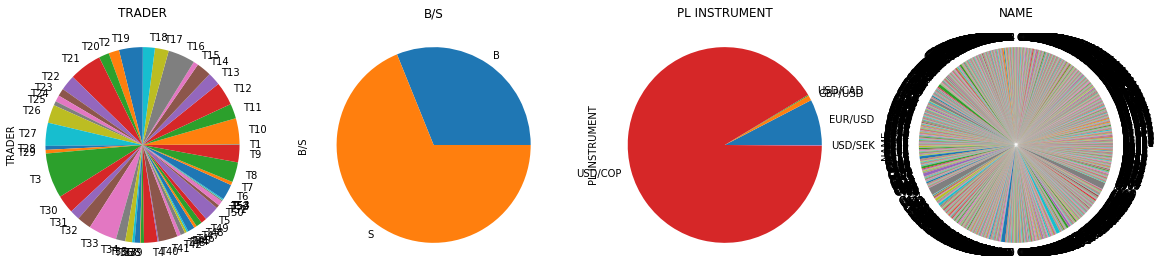

In [224]:
from utils.qual import pie_plots
pie_plots(data, colsqual, piecols=4)

Se seleccionan solo transacciones USD/COP:

In [225]:
from copy import copy
data_usd = copy(data[data['PL INSTRUMENT']=='USD/COP'])

Columnas cualitativas:

In [226]:
cols_qual = [u'TRADER', u'B/S', u'NAME']

Relaciones (implicaciones):

In [227]:
from utils.qual import find_implications
find_implications(data_usd, cols_qual, threshold=0.005)

[(u'TRADER', u'T42', u'B/S', u'S', 0.005485463521667581, 10, 1823),
 (u'NAME', u'C218', u'TRADER', u'T3', 0.005485463521667581, 10, 1823),
 (u'NAME', u'C41', u'TRADER', u'T3', 0.005485463521667581, 10, 1823),
 (u'NAME', u'C44', u'TRADER', u'T3', 0.013713658804168952, 25, 1823),
 (u'NAME', u'C631', u'TRADER', u'T3', 0.007131102578167855, 13, 1823),
 (u'NAME', u'C757', u'TRADER', u'T3', 0.006582556226001097, 12, 1823),
 (u'NAME', u'C9', u'TRADER', u'T3', 0.012068019747668678, 22, 1823),
 (u'NAME', u'C25', u'B/S', u'B', 0.005485463521667581, 10, 1823),
 (u'NAME', u'C757', u'B/S', u'B', 0.006582556226001097, 12, 1823)]

Relaciones (negaciones):

In [228]:
from utils.qual import find_negations
find_negations(data_usd, cols_qual, threshold=0.005)

[(u'TRADER', u'T42', u'B/S', u'B', 0.005485463521667581, 10, 1823),
 (u'NAME', u'C25', u'B/S', u'S', 0.005485463521667581, 10, 1823),
 (u'NAME', u'C757', u'B/S', u'S', 0.006582556226001097, 12, 1823)]

# Clasificación de transacciones por monto

## Montos de transacciones:

In [229]:
montos = data_usd['NOMINAL 0'] * data_usd['RATE 0']

In [230]:
import numpy as np
montos_log = np.log10(montos) 

## Clasificación con K means:

Creación del clasificador

In [231]:
from sklearn.cluster import KMeans
Nclases = 3
kmeans = KMeans(n_clusters=Nclases)

Kmeans

In [232]:
xdata = montos_log.values.reshape(len(montos_log), 1)
kmeans.fit(xdata)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

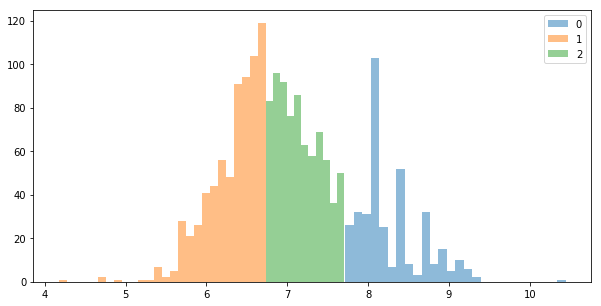

In [233]:
from utils.clust import classes_histogram
classes_histogram(montos_log, kmeans.labels_, Nclases)

In [234]:
data_usd['CLASS_MONTO'] = kmeans.labels_

# Perfilamiento de traders

Extracción de características:

In [235]:
info_traders = []
for trader, g in data_usd.groupby('TRADER'):
    info = {'TRADER': trader}
    for c in range(Nclases):
        for t in ['B', 'S']:
            info['N{}{}'.format(c, t)] = len(g[(g['B/S'] == t) & (g['CLASS_MONTO'] == c)])
    info_traders.append(info)
data_traders =pd.DataFrame(info_traders)
data_traders = data_traders.set_index('TRADER')
data_traders.iloc[0]

N0B     2
N0S     1
N1B    15
N1S    22
N2B     6
N2S    27
Name: T10, dtype: int64

Clustering con k-means:

In [236]:
from sklearn.cluster import KMeans
Ntraderclases = 4
ktraders = KMeans(n_clusters=Ntraderclases, n_jobs=-1, n_init=1000)
ktraders.fit(data_traders.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=1000, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [237]:
np.round(ktraders.cluster_centers_)

array([[   1.,    5.,    0.,    2.,    1.,    3.],
       [   1.,    2.,    7.,   12.,    6.,   17.],
       [ 109.,   40.,    0.,    0.,    0.,    0.],
       [   1.,    1.,   14.,   27.,    9.,   25.]])

In [238]:
ktraders.labels_

array([3, 1, 3, 1, 1, 0, 3, 1, 1, 3, 1, 1, 3, 1, 0, 0, 0, 1, 3, 0, 0, 2, 1,
       1, 1, 3, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1], dtype=int32)

In [239]:
from collections import Counter
Counter(ktraders.labels_)

Counter({0: 27, 1: 18, 2: 1, 3: 7})

# Perfilamiento de clientes

Extracción de características:

In [240]:
info_clients = []
for client, g in data_usd.groupby('NAME'):
    info = {'NAME': client}
    for c in range(Nclases):
        for t in ['B', 'S']:
            info['N{}{}'.format(c, t)] = len(g[(g['B/S'] == t) & (g['CLASS_MONTO'] == c)])
    info_clients.append(info)
data_clients =pd.DataFrame(info_clients)
data_clients = data_clients.set_index('NAME')
data_clients.iloc[0]

N0B    0
N0S    0
N1B    0
N1S    0
N2B    0
N2S    1
Name: C10, dtype: int64

Clustering con k-means:

In [245]:
from sklearn.cluster import KMeans
Nclientsclases = 15
kclients = KMeans(n_clusters=Nclientsclases, n_jobs=-1, n_init=100)
kclients.fit(data_clients.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=100, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [246]:
np.round(kclients.cluster_centers_)

array([[  0.,   0.,   0.,   0.,   0.,   1.],
       [ 20.,   4.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   1.,   0.,  -0.],
       [  0.,   0.,   0.,  -0.,   1.,  -0.],
       [  0.,   0.,   1.,  -0.,   0.,  -0.],
       [  7.,   1.,   0.,   0.,   0.,   0.],
       [  0.,   3.,   0.,  -0.,   0.,   0.],
       [  1.,   0.,   0.,  -0.,   0.,  -0.],
       [  0.,   1.,   0.,   0.,  -0.,  -0.],
       [  1.,   0.,   0.,   0.,   9.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   2.],
       [  2.,   5.,   0.,   0.,   0.,   0.],
       [ 12.,   0.,   0.,   0.,   0.,   0.],
       [ -0.,  -0.,   0.,   2.,   0.,   0.],
       [ -0.,   0.,   0.,   1.,   0.,   1.]])

In [247]:
kclients.labels_

array([0, 4, 0, ..., 3, 2, 0], dtype=int32)

In [248]:
from collections import Counter
Counter(kclients.labels_)

Counter({0: 492,
         1: 2,
         2: 403,
         3: 173,
         4: 210,
         5: 4,
         6: 20,
         7: 42,
         8: 110,
         9: 1,
         10: 25,
         11: 4,
         12: 2,
         13: 21,
         14: 15})